# Imports

In [37]:
# # import itertools
# # import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import numpy as np
import pickle as pkl
import seaborn as sns
# # from sklearn.metrics import confusion_matrix
# # from sklearn.metrics import precision_recall_fscore_support
# # from sklearn.ensemble import RandomForestRegressor
# # from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon
# # import tqdm
# # from typing import Optional
# # import xarray

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
# from backend import loading_utils
# from backend import metrics_utils
# from backend import return_period_metrics
# from backend import skill_prediction_utils

# Load Return Period Metrics

In [23]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [24]:
from backend import data_paths
from backend import evaluation_utils
# from backend import gauge# Load Return Period Metrics

_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [25]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Gauge Groups

In [30]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


In [31]:
ungauged_gauge_groups = gauge_groups_utils.load_all_ungauged_gauge_groups()

Working on kfold_splits ...


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 6657.63it/s]


Working on continent_splits ...


100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2992.01it/s]


Working on climate_splits ...


100%|██████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 3609.08it/s]


# F1 Distributions over Continents

In [33]:
# Assign continents to each gauge.
continent_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}
gauge_continent_df = pd.Series(index=gauges, dtype=str, name='Continent')
for gauge in gauges:
    continent = [continent for continent, split_gauges in ungauged_gauge_groups['continent_splits'].items() if gauge in split_gauges][0]
    gauge_continent_df.loc[gauge] = continent_names[continent]

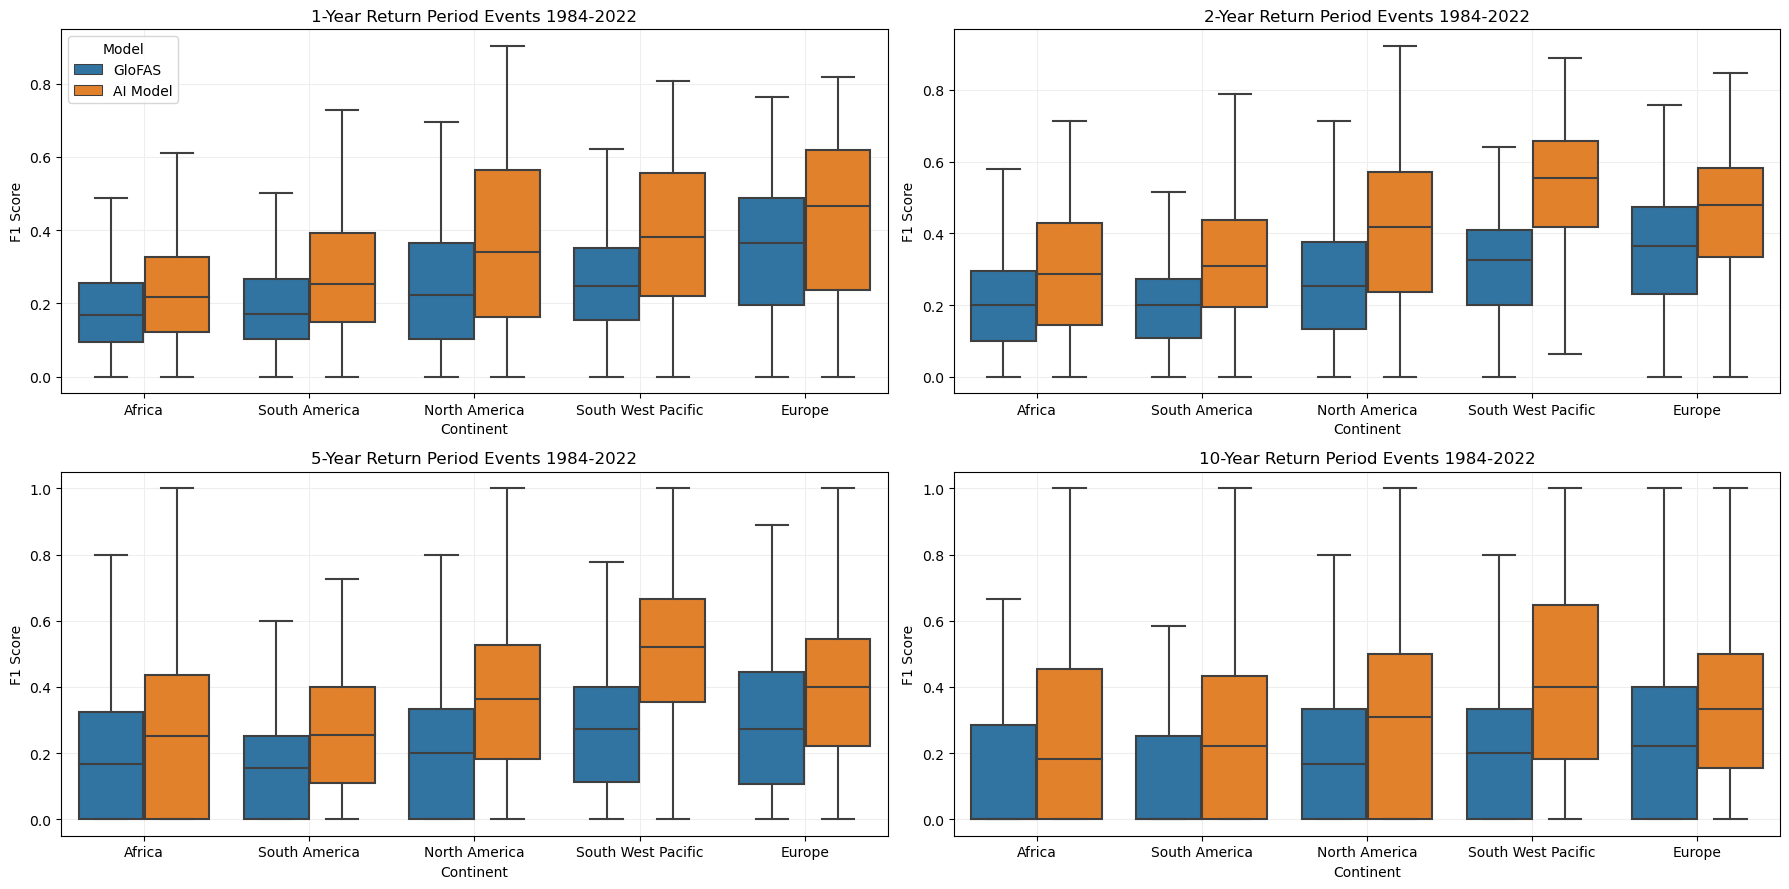

In [43]:
lead_time = 0
return_periods = evaluation_utils.RETURN_PERIODS[:-2]
experiments = ['glofas_reanalysis', 'kfold_splits']
experiment_names = {experiment: evaluation_utils.EXPERIMENT_NAMES[experiment] for experiment in experiments}
split_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}

metric = 'F1 Score'

fig, axes = plt.subplots(2, 2, figsize=(18, 9))

for ridx, (ax, return_period) in enumerate(zip(axes.flatten(), return_periods)):

    if metric.lower() == 'precision':
        plotdata = pd.concat(
            [
                gauge_continent_df,
                precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
            ], axis=1
        ).dropna()
    elif metric.lower() == 'recall':
        plotdata = pd.concat(
            [
                gauge_continent_df,
                recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
            ], axis=1
        ).dropna()
    elif metric.lower() == 'f1 score':
        plotdata = pd.concat(
            [
                gauge_continent_df,
                f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
            ], axis=1
        ).dropna()
    else:
        raise ValueError('Unknown metric')

    plotdata.rename(columns=experiment_names, inplace=True)
    dd = pd.melt(
        plotdata,
        id_vars=['Continent'],
        value_vars=experiment_names.values(),
        var_name='Model',
        value_name=metric
    )
    sns.boxplot(
        data=dd,
        x='Continent',
        y=metric,
        hue='Model',
        ax=ax,
        showfliers=False
    )

    ax.set_title(f'{int(return_period)}-Year Return Period Events 1984-2022')
    ax.grid(c='#EEE')
    ax.set_axisbelow(True)

    if ax != axes.flatten()[0]:
        ax.get_legend().remove()

plt.tight_layout()

evaluation_utils.save_figure(data_paths.CONTINENT_RELIABILITY_SCORES_DISTRIBUTIONS_FILENAME)

# GloFAS Difference Between Continents

## Precisions

In [54]:
for return_period in evaluation_utils.RETURN_PERIODS:
    df = pd.concat(
        [
            gauge_continent_df,
            precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
        ], axis=1
    ).dropna()

    continent_means = df.groupby(['Continent'])['glofas_reanalysis'].mean()
    
    print(f'--- {return_period = }-----------------------------------------------')
    print(continent_means)
    
    frac_diff = (continent_means.max() - continent_means.min()) / continent_means.max()
    print(frac_diff)

--- return_period = 1.01-----------------------------------------------
Continent
Africa                0.253210
Europe                0.382247
North America         0.285695
South America         0.282522
South West Pacific    0.309222
Name: glofas_reanalysis, dtype: float64
0.33757398920920106
--- return_period = 2-----------------------------------------------
Continent
Africa                0.255968
Europe                0.371424
North America         0.291130
South America         0.224586
South West Pacific    0.330688
Name: glofas_reanalysis, dtype: float64
0.39533815709438314
--- return_period = 5-----------------------------------------------
Continent
Africa                0.211763
Europe                0.290501
North America         0.226703
South America         0.178403
South West Pacific    0.274284
Name: glofas_reanalysis, dtype: float64
0.38587931368746864
--- return_period = 10-----------------------------------------------
Continent
Africa                0.150058
Euro

## Recalls

In [55]:
for return_period in evaluation_utils.RETURN_PERIODS:
    df = pd.concat(
        [
            gauge_continent_df,
            recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
        ], axis=1
    ).dropna()

    continent_means = df.groupby(['Continent'])['glofas_reanalysis'].mean()
    
    print(f'--- {return_period = }-----------------------------------------------')
    print(continent_means)
    
    frac_diff = (continent_means.max() - continent_means.min()) / continent_means.max()
    print(frac_diff)

--- return_period = 1.01-----------------------------------------------
Continent
Africa                0.159012
Europe                0.338362
North America         0.236093
South America         0.162268
South West Pacific    0.242310
Name: glofas_reanalysis, dtype: float64
0.5300539871068305
--- return_period = 2-----------------------------------------------
Continent
Africa                0.190297
Europe                0.341745
North America         0.252098
South America         0.194756
South West Pacific    0.320944
Name: glofas_reanalysis, dtype: float64
0.4431600333201582
--- return_period = 5-----------------------------------------------
Continent
Africa                0.168238
Europe                0.278983
North America         0.220050
South America         0.169345
South West Pacific    0.280292
Name: glofas_reanalysis, dtype: float64
0.39977650676654675
--- return_period = 10-----------------------------------------------
Continent
Africa                0.115283
Europe

## F1s

In [56]:
for return_period in evaluation_utils.RETURN_PERIODS:
    df = pd.concat(
        [
            gauge_continent_df,
            f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
        ], axis=1
    ).dropna()

    continent_means = df.groupby(['Continent'])['glofas_reanalysis'].mean()
    
    print(f'--- {return_period = }-----------------------------------------------')
    print(continent_means)
    
    frac_diff = (continent_means.max() - continent_means.min()) / continent_means.max()
    print(frac_diff)

--- return_period = 1.01-----------------------------------------------
Continent
Africa                0.181422
Europe                0.344759
North America         0.244099
South America         0.192472
South West Pacific    0.255257
Name: glofas_reanalysis, dtype: float64
0.4737705982560068
--- return_period = 2-----------------------------------------------
Continent
Africa                0.203080
Europe                0.347060
North America         0.261622
South America         0.201963
South West Pacific    0.314739
Name: glofas_reanalysis, dtype: float64
0.418075671268796
--- return_period = 5-----------------------------------------------
Continent
Africa                0.194488
Europe                0.276865
North America         0.215750
South America         0.163722
South West Pacific    0.267153
Name: glofas_reanalysis, dtype: float64
0.40865840185954433
--- return_period = 10-----------------------------------------------
Continent
Africa                0.151569
Europe 

# Statistical Tests with GloFAS Europe

In [84]:
lead_time = 0
return_periods = evaluation_utils.RETURN_PERIODS[:-2]
experiments = ['glofas_reanalysis', 'kfold_splits']
experiment_names = {experiment: evaluation_utils.EXPERIMENT_NAMES[experiment] for experiment in experiments}
split_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}

for metric in ['precision', 'recall', 'f1 score']:
    for ridx, (ax, return_period) in enumerate(zip(axes.flatten(), return_periods)):

        if metric.lower() == 'precision':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                    precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'recall':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                    recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'f1 score':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                    f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        else:
            raise ValueError('Unknown metric')

        plotdata.rename(columns=experiment_names, inplace=True)
        dd = pd.melt(plotdata, id_vars=['Continent'], value_vars=experiment_names.values(), var_name='Model', value_name=metric)

        # Statistical tests over continents.
        europe_glofas_df = dd.loc[(dd['Continent'] == 'Europe') & (dd['Model'] == evaluation_utils.EXPERIMENT_NAMES['glofas_reanalysis'])]
        for continent in set(dd['Continent']):
            continent_google_df = dd.loc[(dd['Continent'] == continent) & (dd['Model'] == evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])]
            stats = ranksums(europe_glofas_df[metric], continent_google_df[metric])

            if stats.statistic > 0 and stats.pvalue < 1e-2:
                print(f'--- Test Against GloFAS Europe: {metric =} --- {continent =} --- {return_period =} ----')
                print(stats)
                frac_diff = (europe_glofas_df[metric].mean() - continent_google_df[metric].mean()) / europe_glofas_df[metric].mean()
                print(frac_diff)
                print('-------------------------------------------------------------------------------\n')

--- Test Against GloFAS Europe: metric ='precision' --- continent ='South America' --- return_period =1.01 ----
RanksumsResult(statistic=5.270930853214563, pvalue=1.3573360199060508e-07)
0.18466425105636386
-------------------------------------------------------------------------------

--- Test Against GloFAS Europe: metric ='precision' --- continent ='Africa' --- return_period =1.01 ----
RanksumsResult(statistic=10.667693628652717, pvalue=1.4416024300009266e-26)
0.32419812103588
-------------------------------------------------------------------------------

--- Test Against GloFAS Europe: metric ='precision' --- continent ='South America' --- return_period =2 ----
RanksumsResult(statistic=4.591995780040085, pvalue=4.3902724811827615e-06)
0.15690002382331558
-------------------------------------------------------------------------------

--- Test Against GloFAS Europe: metric ='precision' --- continent ='Africa' --- return_period =2 ----
RanksumsResult(statistic=4.474824735525376, pv

0.24062262524074218

# Continent-by-Continent Statistical Tests

In [81]:
lead_time = 0
return_periods = evaluation_utils.RETURN_PERIODS[:-2]
experiments = ['glofas_reanalysis', 'kfold_splits']
experiment_names = {experiment: evaluation_utils.EXPERIMENT_NAMES[experiment] for experiment in experiments}
split_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}

for metric in ['precision', 'recall', 'f1 score']:
    for ridx, (ax, return_period) in enumerate(zip(axes.flatten(), return_periods)):

        if metric.lower() == 'precision':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                    precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'recall':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                    recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'f1 score':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
                    f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        else:
            raise ValueError('Unknown metric')

        plotdata.rename(columns=experiment_names, inplace=True)
        dd = pd.melt(plotdata, id_vars=['Continent'], value_vars=experiment_names.values(), var_name='Model', value_name=metric)

        # Statistical tests over continents.
        for continent in set(dd['Continent']):
            google_df = dd.loc[(dd['Continent'] == continent) & (
                dd['Model'] == evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])]
            glofas_df = dd.loc[(dd['Continent'] == continent) & (
                dd['Model'] == evaluation_utils.EXPERIMENT_NAMES['glofas_reanalysis'])]
            mean_difference = google_df[metric].mean() - glofas_df[metric].mean()
            stats = wilcoxon(google_df[metric], glofas_df[metric])
            
            if mean_difference < 0 or stats.pvalue > 1e-2:
                print(f'--- Continent-to-Continent Test: {metric=} --- {continent=} --- {return_period=} ----')
                print('Mean Difference:', mean_difference)
                print(stats)
                print('-------------------------------------------------------\n')

--- Continent-to-Continent Test: metric='precision' --- continent='Africa' --- return_period=1.01 ----
Mean Difference: 0.00511287913176367
WilcoxonResult(statistic=42702.0, pvalue=0.27536593419158106)
-------------------------------------------------------

